In [1]:
import torch
from torchvision.models import inception_v3
from torchvision import transforms
from torch.nn.functional import adaptive_avg_pool2d

from PIL import Image
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import torch
_ = torch.manual_seed(123)
from torchmetrics.image.fid import FrechetInceptionDistance

device = torch.device(f'cuda:3' if torch.cuda.is_available() else 'cpu')
fid = FrechetInceptionDistance(feature=64).to(device)

In [41]:
dir = '/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/mbt2018'
for name in os.listdir(dir):
    print(name)

celebA
fairface


In [38]:
generated_images_path = '/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/jpeg/q_1'
meta_data_path = '/media/global_data/fair_neural_compression_data/datasets/RFW/clean_metadata/numerical_labels.csv'
clean_images_path = '/media/global_data/fair_neural_compression_data/datasets/RFW/data_64'

meta_data_inf = pd.read_csv(meta_data_path).to_numpy()

In [14]:
def get_images(meta_data_inf, path):
    image_tensors = []
    for meta_data in tqdm(meta_data_inf, total=len(meta_data_inf)):
        file_path = os.path.join(path, meta_data[2], meta_data[1])
        image = Image.open(file_path).convert('RGB')
        image_tensor = transforms.ToTensor()(image)
        image_tensors.append(image_tensor)
    
    image_tensors = torch.stack(image_tensors, dim=0)
    return image_tensors

In [39]:
generated_image_tensors = get_images(meta_data_inf, generated_images_path)

100%|██████████| 40607/40607 [00:08<00:00, 4756.98it/s]


In [30]:
generated_image_tensors = generated_image_tensors.to(device).to(torch.uint8)

In [31]:
clean_image_tensors = get_images(meta_data_inf, clean_images_path)

100%|██████████| 40607/40607 [00:10<00:00, 3957.30it/s]


In [32]:
clean_image_tensors = clean_image_tensors.to(device).to(torch.uint8)

In [33]:
def update_fid_in_batches(fid, images, batch_size=128, real=True):
    for i in range(0, len(images), batch_size):
        batch = images[i:i + batch_size]
        fid.update(batch, real=real)

In [34]:
update_fid_in_batches(fid, clean_image_tensors, batch_size=64, real=True)
update_fid_in_batches(fid, generated_image_tensors, batch_size=64, real=False)


In [48]:
float(fid.compute())

1.4183015082380734e-05

- mbt2018
    - celebA
        - q0001: 6.5600e-05
        - q0009: 2.8195e-05
        - q1:
        - q2:
        - q3: 1.9363e-05
        
    - fairface
        - q0001: 9.0552e-05
        - q0009: 1.4183e-05
        - q1: 
        - q2:
        - q3:


In [4]:
model = inception_v3(pretrained=True, transform_input=False)
model.fc = torch.nn.Identity()  # Remove the final classification layer
model = model.eval()

/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rasta/.conda/envs/fnc_eval/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
import json

bias_data_path = '/media/global_data/fair_neural_compression_data/fairness.json'
fid_data_path = '/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64/fid.json'
with open(bias_data_path, 'r') as json_file:
    bias_data = json.load(json_file)
    
with open(fid_data_path, 'r') as json_file:
    fid_data = json.load(json_file)

In [34]:
bias_data.keys()

dict_keys(['hyperprior', 'qres17m', 'cheng2020-attn', 'mbt2018'])

In [35]:
data_path = '/media/global_data/fair_neural_compression_data/decoded_rfw/decoded_64x64'
bpp_data = {}
for model_name in fid_data:
    if model_name == 'jpeg':
        continue
    print(f'model_name: {model_name}')
    bpp_data[model_name] = {}
    model_path = f'{data_path}/{model_name}'
    for dataset in fid_data[model_name]:
        print(f'dataset: {dataset}')
        bpp_data[model_name][dataset] = {}
        dataset_path = f'{model_path}/{dataset}'
        for quality in fid_data[model_name][dataset]:
            stats_path = f'{dataset_path}/{quality}/stats.json'
            with open(stats_path, 'r') as json_file:
                stats_data = json.load(json_file)
            if "results" in stats_data:
                bpp_data[model_name][dataset][quality] = stats_data['results']['bpp']
            elif "est_bpp" in stats_data:
                bpp_data[model_name][dataset][quality] = stats_data['est_bpp']
bpp_data

model_name: qres17m_lmb_64
dataset: fairface
dataset: celebA
model_name: mbt2018
dataset: fairface
dataset: celebA
model_name: hyperprior
dataset: fairface
dataset: celebA
model_name: cheng2020-attn
dataset: fairface
dataset: celebA


{'qres17m_lmb_64': {'fairface': {'1': 0.00886532558800188,
   '3': 0.02282370359182936,
   '12': 0.7223974981481218,
   '9': 0.404614933002803,
   '6': 0.15795940315773765},
  'celebA': {'1': 0.010865931109864174,
   '3': 0.01401326913838128,
   '12': 0.6997467670037869,
   '9': 0.4595163508693375,
   '6': 0.20318071834509452}},
 'mbt2018': {'fairface': {'q_0001': 0.016809767051736497,
   'q_3': 0.5218644282039855,
   'q_0009': 0.1548888608237158,
   'q_1': 0.22898081410871188,
   'q_2': 0.3578851009571441},
  'celebA': {'q_0001': 0.020051372451441445,
   'q_3': 0.5174065784374351,
   'q_0009': 0.15650851445510033,
   'q_1': 0.2411556771732332,
   'q_2': 0.3580438339891074}},
 'hyperprior': {'fairface': {'q_0001': 0.02389208837651166,
   'q_3': 0.5033693308406143,
   'q_0009': 0.1269041086678334,
   'q_1': 0.21954348773464366,
   'q_2': 0.34495363053285133},
  'celebA': {'q_0001': 0.03605595400890076,
   'q_3': 0.5228528544601424,
   'q_0009': 0.14813256551099604,
   'q_1': 0.236050330

In [36]:
fid_data['qres17m'] = fid_data.pop('qres17m_lmb_64')

In [37]:
bpp_data['qres17m'] = bpp_data.pop('qres17m_lmb_64')

In [38]:
def is_integer_string(s):
    try:
        int(s)
        return True
    except ValueError:
        return False

def sort_dict(d):
    """Sort dictionary based on the type of keys."""
    all_keys_are_int_strings = all(is_integer_string(key) for key in d.keys())
    
    if all_keys_are_int_strings:
        sorted_dict = {key: d[key] for key in sorted(d, key=lambda k: int(k))}
    else:
        sorted_dict = {key: d[key] for key in sorted(d)}
    
    return sorted_dict

In [39]:
for model_name in bpp_data:
    for dataset_name in bpp_data[model_name]:
        bpp_data[model_name][dataset_name] = sort_dict(bpp_data[model_name][dataset_name])
bpp_data

{'mbt2018': {'fairface': {'q_0001': 0.016809767051736497,
   'q_0009': 0.1548888608237158,
   'q_1': 0.22898081410871188,
   'q_2': 0.3578851009571441,
   'q_3': 0.5218644282039855},
  'celebA': {'q_0001': 0.020051372451441445,
   'q_0009': 0.15650851445510033,
   'q_1': 0.2411556771732332,
   'q_2': 0.3580438339891074,
   'q_3': 0.5174065784374351}},
 'hyperprior': {'fairface': {'q_0001': 0.02389208837651166,
   'q_0009': 0.1269041086678334,
   'q_1': 0.21954348773464366,
   'q_2': 0.34495363053285133,
   'q_3': 0.5033693308406143},
  'celebA': {'q_0001': 0.03605595400890076,
   'q_0009': 0.14813256551099604,
   'q_1': 0.236050330956911,
   'q_2': 0.3631279615610438,
   'q_3': 0.5228528544601424}},
 'cheng2020-attn': {'fairface': {'q_0001': 0.015044328461066748,
   'q_0009': 0.13340453971414487,
   'q_1': 0.216410437588412,
   'q_2': 0.31665372603601366,
   'q_3': 0.44806759830559767},
  'celebA': {'q_0001': 0.027202235793998834,
   'q_0009': 0.1385776092247803,
   'q_1': 0.2097212241

In [40]:
fid_data

{'mbt2018': {'fairface': {'q_0001': 1.7237855195999146,
   'q_3': 0.10548420250415802,
   'q_0009': 0.3387182950973511,
   'q_1': 0.22478815913200378,
   'q_2': 0.1252719908952713},
  'celebA': {'q_0001': 1.659135103225708,
   'q_3': 0.14106233417987823,
   'q_0009': 0.34678661823272705,
   'q_1': 0.2327074557542801,
   'q_2': 0.19979222118854523}},
 'hyperprior': {'fairface': {'q_0001': 1.1596003770828247,
   'q_3': 0.11870288103818893,
   'q_0009': 0.3096502721309662,
   'q_1': 0.19875797629356384,
   'q_2': 0.11740191280841827},
  'celebA': {'q_0001': 0.7060130834579468,
   'q_3': 0.14054597914218903,
   'q_0009': 0.3358023762702942,
   'q_1': 0.1877453327178955,
   'q_2': 0.13576026260852814}},
 'jpeg': {'q_4': 1.24770188331604,
  'q_90': 0.24473950266838074,
  'q_3': 1.6337746381759644,
  'q_55': 0.41978883743286133,
  'q_50': 0.43433961272239685,
  'q_25': 0.5125191807746887,
  'q_75': 0.35554778575897217,
  'q_1': 1.5991932153701782,
  'q_95': 0.1840205192565918,
  'q_35': 0.461

In [41]:
for model_name in fid_data:
    if model_name == 'jpeg':
        continue
    for dataset_name in fid_data[model_name]:
        fid_data[model_name][dataset_name] = sort_dict(fid_data[model_name][dataset_name])
fid_data

{'mbt2018': {'fairface': {'q_0001': 1.7237855195999146,
   'q_0009': 0.3387182950973511,
   'q_1': 0.22478815913200378,
   'q_2': 0.1252719908952713,
   'q_3': 0.10548420250415802},
  'celebA': {'q_0001': 1.659135103225708,
   'q_0009': 0.34678661823272705,
   'q_1': 0.2327074557542801,
   'q_2': 0.19979222118854523,
   'q_3': 0.14106233417987823}},
 'hyperprior': {'fairface': {'q_0001': 1.1596003770828247,
   'q_0009': 0.3096502721309662,
   'q_1': 0.19875797629356384,
   'q_2': 0.11740191280841827,
   'q_3': 0.11870288103818893},
  'celebA': {'q_0001': 0.7060130834579468,
   'q_0009': 0.3358023762702942,
   'q_1': 0.1877453327178955,
   'q_2': 0.13576026260852814,
   'q_3': 0.14054597914218903}},
 'jpeg': {'q_4': 1.24770188331604,
  'q_90': 0.24473950266838074,
  'q_3': 1.6337746381759644,
  'q_55': 0.41978883743286133,
  'q_50': 0.43433961272239685,
  'q_25': 0.5125191807746887,
  'q_75': 0.35554778575897217,
  'q_1': 1.5991932153701782,
  'q_95': 0.1840205192565918,
  'q_35': 0.461

In [42]:
bpp_data

{'mbt2018': {'fairface': {'q_0001': 0.016809767051736497,
   'q_0009': 0.1548888608237158,
   'q_1': 0.22898081410871188,
   'q_2': 0.3578851009571441,
   'q_3': 0.5218644282039855},
  'celebA': {'q_0001': 0.020051372451441445,
   'q_0009': 0.15650851445510033,
   'q_1': 0.2411556771732332,
   'q_2': 0.3580438339891074,
   'q_3': 0.5174065784374351}},
 'hyperprior': {'fairface': {'q_0001': 0.02389208837651166,
   'q_0009': 0.1269041086678334,
   'q_1': 0.21954348773464366,
   'q_2': 0.34495363053285133,
   'q_3': 0.5033693308406143},
  'celebA': {'q_0001': 0.03605595400890076,
   'q_0009': 0.14813256551099604,
   'q_1': 0.236050330956911,
   'q_2': 0.3631279615610438,
   'q_3': 0.5228528544601424}},
 'cheng2020-attn': {'fairface': {'q_0001': 0.015044328461066748,
   'q_0009': 0.13340453971414487,
   'q_1': 0.216410437588412,
   'q_2': 0.31665372603601366,
   'q_3': 0.44806759830559767},
  'celebA': {'q_0001': 0.027202235793998834,
   'q_0009': 0.1385776092247803,
   'q_1': 0.2097212241

/tmp/ipykernel_291745/3001461675.py:41: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(fids, bias, s=sizes, c=model_colors[model_name], marker=dataset_makers[dataset_name],


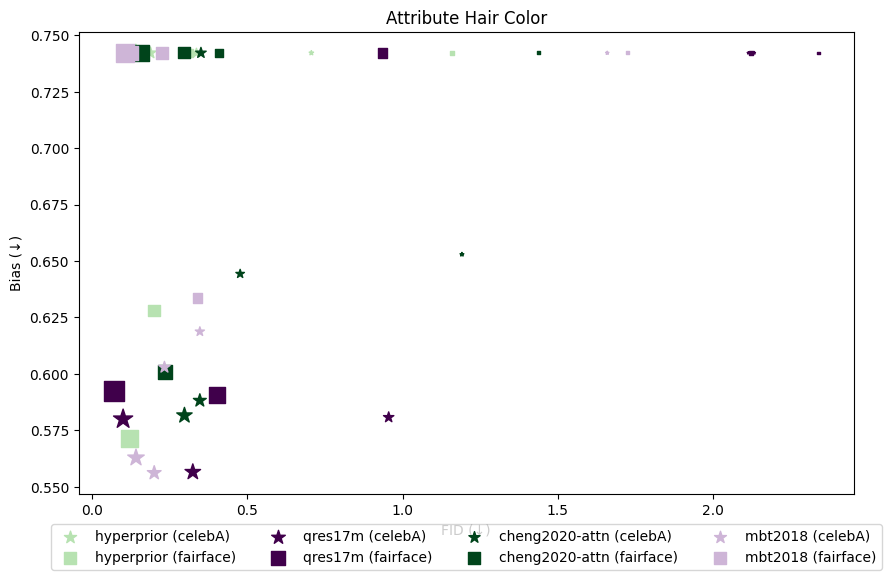

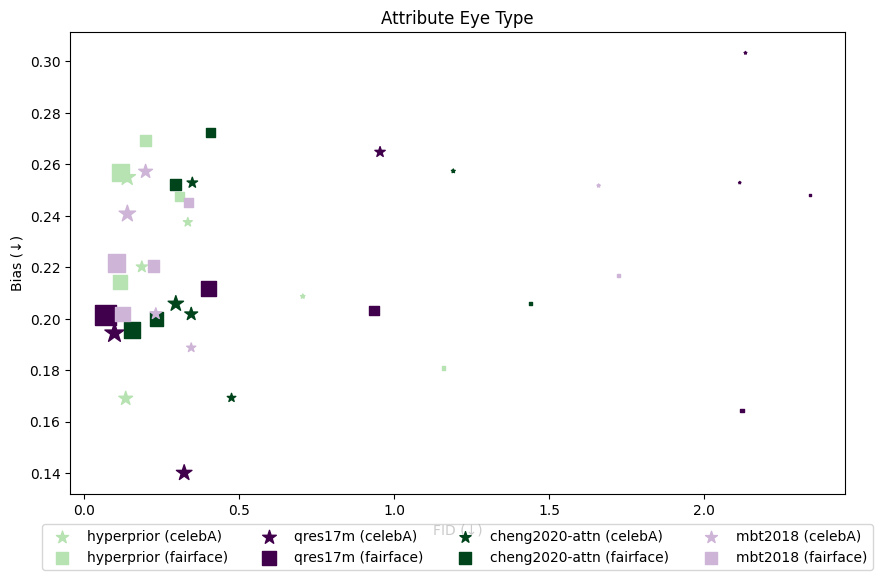

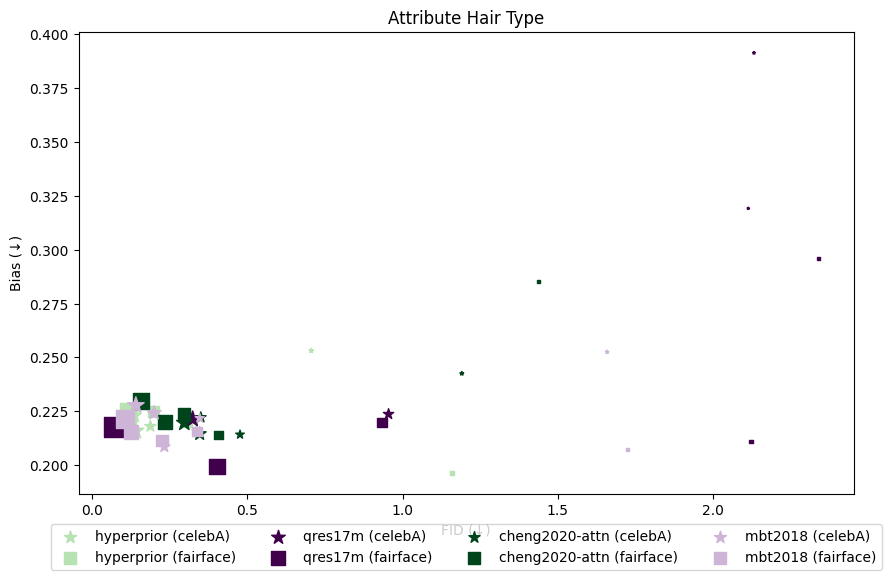

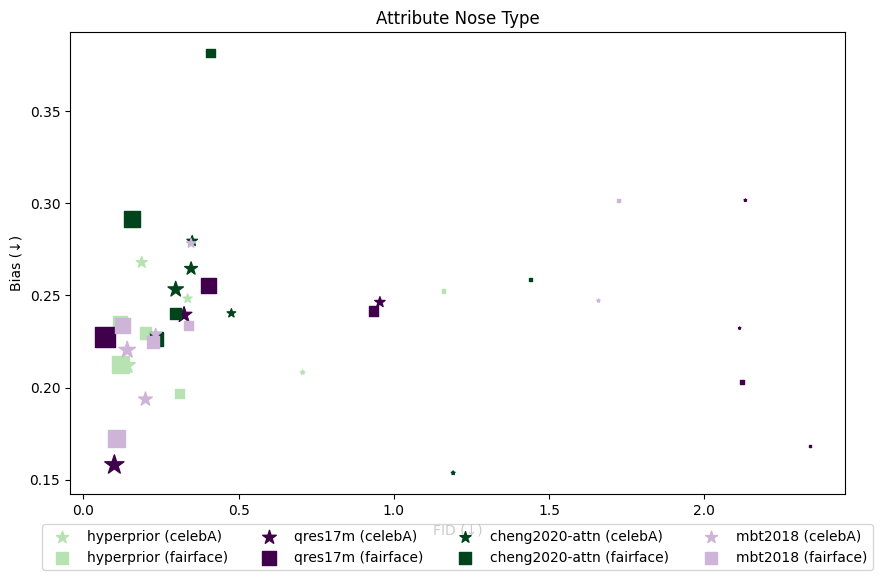

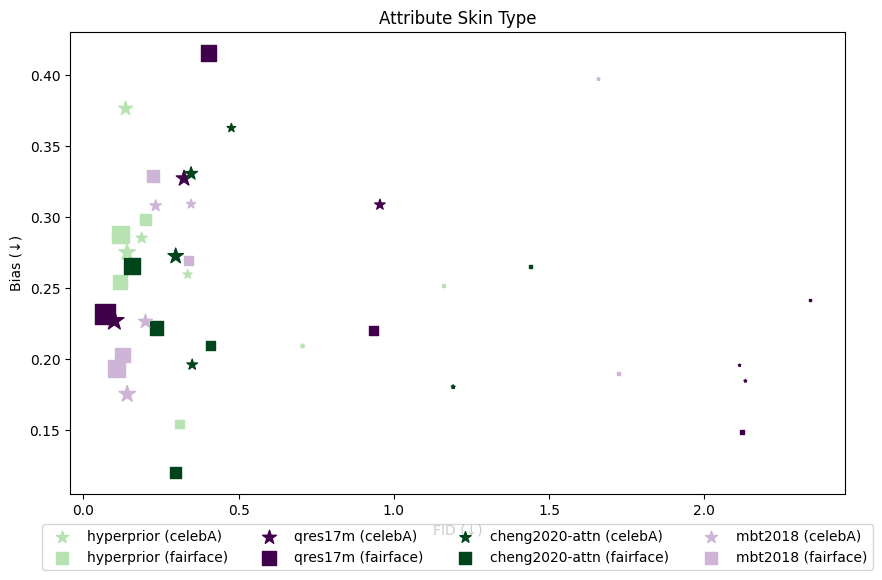

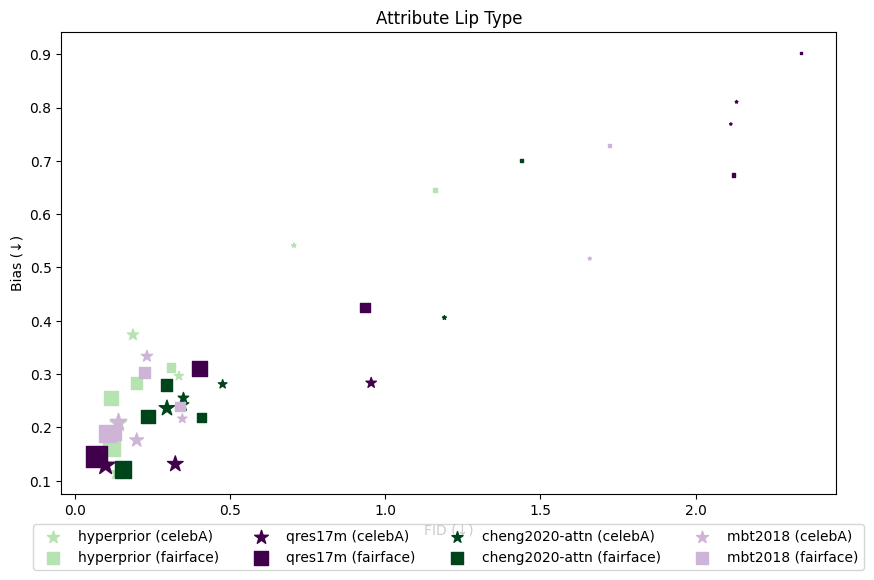

In [78]:
import matplotlib.pyplot as plt
# model_markers = {
#     'qres17m': 'o',
#     'mbt2018': 's',
#     'hyperprior': '*',
#     'cheng2020-attn': '^'
# }
# dataset_colors = {
#     'celebA': '#A52A2A',
#     'fairface': '#04D8B2'
# }
cmap = plt.get_cmap('PRGn')

# Sample 4 colors from the colormap
colors = cmap(np.linspace(0, 1, 4))

model_colors = {
    'qres17m': colors[0],
    'mbt2018': colors[1],
    'hyperprior': colors[2],
    'cheng2020-attn': colors[3]
}

dataset_makers = {
    'celebA': '*',
    'fairface': 's' 
}

bpp_scale = 300
attributes = ['hair_color', 'eye_type', 'hair_type', 'nose_type', 'skin_type', 'lip_type']

for attribute in attributes:
    plt.figure(figsize=(10, 6))
    for model_name in bias_data:
        for dataset_name in bias_data[model_name]:
            bias = bias_data[model_name][dataset_name][attribute]
            bpps = list(bpp_data[model_name][dataset_name].values())
            fids = list(fid_data[model_name][dataset_name].values())
            sizes = np.array(bpps) * bpp_scale
            
            plt.scatter(fids, bias, s=sizes, c=model_colors[model_name], marker=dataset_makers[dataset_name], 
                        label=f'{model_name} ({dataset_name})')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4)

    plt.xlabel('FID (\u2193)')
    plt.ylabel('Bias (\u2193)')
    plt.title(f'Attribute {" ".join(attribute.split("_")).title()}')
            

In [ ]:
ValueError: 'tab9' is not a valid value for name; supported values are 'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r'
